In [1]:
# =========================================================
# Kaggle setup: librerie + login Hugging Face
# =========================================================

import os, math, difflib, inspect
from pathlib import Path
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from huggingface_hub import login
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.models.attention_processor import AttnProcessor
from transformers import CLIPProcessor, CLIPModel


2025-08-05 16:33:36.150554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754411616.368210      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754411616.435333      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 20230330

In [3]:
# --------- GPU / PATHS ----------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = Path("/kaggle/working/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
# =========================================================
# Utils visuali
# =========================================================
def show_pair(img1, img2, titles=("Original", "Edited")):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img1); plt.title(titles[0]); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img2); plt.title(titles[1]); plt.axis("off")
    plt.show()

# =========================================================
# Carica Stable Diffusion v1.5 (text2img) + ottimizzazioni
# =========================================================
dtype = torch.float16 if DEVICE == "cuda" else torch.float32
sd_t2i = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=dtype,
    safety_checker=None,   # opzionale: più veloce
).to(DEVICE)

# Scheduler: DDIM (tipico per P2P)
sd_t2i.scheduler = DDIMScheduler.from_config(sd_t2i.scheduler.config)

# Ottimizzazioni (tolleranti: se non disponibili, ignora)
try:
    sd_t2i.enable_xformers_memory_efficient_attention()
except Exception:
    pass
sd_t2i.enable_attention_slicing("max")
sd_t2i.enable_vae_slicing()

tokenizer = sd_t2i.tokenizer  # CLIP tokenizer dal pipeline



model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
# =========================================================
# CLIP scoring (opzionale, per confronto prima/dopo)
# =========================================================
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

@torch.no_grad()
def clip_embed(image, text):
    inputs = clip_processor(images=image, text=[text], return_tensors="pt", padding=True).to(DEVICE)
    out = clip_model(**inputs)
    return out.image_embeds[0], out.text_embeds[0]

@torch.no_grad()
def clip_directional_similarity(img1, img2, txt1, txt2):
    im1, _ = clip_embed(img1, txt1)
    im2, _ = clip_embed(img2, txt2)
    _, t1 = clip_embed(Image.new("RGB",(224,224), "white"), txt1)
    _, t2 = clip_embed(Image.new("RGB",(224,224), "white"), txt2)
    dir_img = im2 - im1
    dir_txt = t2  - t1
    return torch.nn.functional.cosine_similarity(dir_img, dir_txt, dim=0).item()

@torch.no_grad()
def clip_image_similarity(img1, img2):
    im1, _ = clip_embed(img1, " ")
    im2, _ = clip_embed(img2, " ")
    return torch.nn.functional.cosine_similarity(im1, im2, dim=0).item()

@torch.no_grad()
def clip_image_caption_similarity(image, caption):
    im_feat, txt_feat = clip_embed(image, caption)
    return torch.nn.functional.cosine_similarity(im_feat, txt_feat, dim=0).item()


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
# # =========================================================
# # Helpers tokenizzazione / allineamento parole→token (CLIP)
# # =========================================================
# def tokenize_ids(text, tokenizer):
#     ids = tokenizer(text, return_tensors="pt", padding="max_length",
#                     truncation=True, max_length=tokenizer.model_max_length).input_ids[0]
#     return ids  # tensor [77]

# def find_all_subseq(haystack, needle):
#     """Trova tutte le occorrenze di needle (lista int) in haystack (lista int). Ritorna lista di (start,end)."""
#     out = []
#     if not needle or len(haystack) < len(needle):
#         return out
#     for i in range(len(haystack) - len(needle) + 1):
#         if haystack[i:i+len(needle)] == needle:
#             out.append((i, i+len(needle)))
#     return out

# def word_token_spans(prompt, word, tokenizer):
#     """
#     Trova TUTTE le occorrenze di 'word' nel prompt e per ognuna ritorna la span di token [start,end) (senza BOS/EOS).
#     Usa il trucco dello spazio iniziale tipico BPE.
#     """
#     full_ids = tokenize_ids(prompt, tokenizer).tolist()
#     core = full_ids[1:-1]  # rimuovi BOS/EOS

#     patterns = []
#     # prima con spazio
#     pat1 = tokenizer(" " + word, add_special_tokens=False).input_ids
#     # poi senza spazio (fallback)
#     pat2 = tokenizer(word, add_special_tokens=False).input_ids

#     for pat in [pat1, pat2]:
#         for (s,e) in find_all_subseq(core, pat):
#             patterns.append((s+1, e+1))  # shift +1 per riallineare con prompt completo
#     # rimuovi duplicati preservando l'ordine
#     uniq = []
#     seen = set()
#     for se in patterns:
#         if se not in seen:
#             uniq.append(se); seen.add(se)
#     return uniq  # lista di tuple (start,end)

# def align_words(src_text, tgt_text):
#     """Allinea parole uguali tra source e target (split by space) con difflib."""
#     src_words = src_text.strip().split()
#     tgt_words = tgt_text.strip().split()
#     sm = difflib.SequenceMatcher(a=src_words, b=tgt_words)
#     pairs = []
#     for tag, i1, i2, j1, j2 in sm.get_opcodes():
#         if tag == "equal":
#             for k in range(i2 - i1):
#                 pairs.append((i1 + k, j1 + k))
#     return pairs, src_words, tgt_words

# def build_token_mapping(src_prompt, tgt_prompt, tokenizer):
#     """
#     Crea mapping token-to-token per parole 'invarianti' (uguali tra i due prompt).
#     Ritorna:
#       src_ids, tgt_ids, mapping (lista di (src_tok_idx, tgt_tok_idx))
#     """
#     src_ids = tokenize_ids(src_prompt, tokenizer)
#     tgt_ids = tokenize_ids(tgt_prompt, tokenizer)

#     word_pairs, src_words, tgt_words = align_words(src_prompt, tgt_prompt)
#     mapping = []

#     # Per ogni parola uguale, associa spans in ordine (gestisce ripetizioni)
#     for (i_src, i_tgt) in word_pairs:
#         w_src = src_words[i_src]; w_tgt = tgt_words[i_tgt]
#         src_spans = word_token_spans(src_prompt, w_src, tokenizer)
#         tgt_spans = word_token_spans(tgt_prompt, w_tgt, tokenizer)
#         if not src_spans or not tgt_spans:
#             continue
#         # confronta numero di token effettivi (flatten spans)
#         src_tokens = [i for (s,e) in src_spans for i in range(s,e)]
#         tgt_tokens = [i for (s,e) in tgt_spans for i in range(s,e)]
#         L = min(len(src_tokens), len(tgt_tokens))
#         for k in range(L):
#             mapping.append((src_tokens[k], tgt_tokens[k]))

#     # dedup
#     mapping = list(dict.fromkeys(mapping))
#     return src_ids, tgt_ids, mapping

# # =========================================================
# # Prompt-to-Prompt: Controller + AttnProcessor custom
# # =========================================================
# class P2PController:
#     """
#     Registra e sostituisce le cross-attention maps in stile Prompt-to-Prompt.
#     - 'store' pass: salva attn_probs (per modulo e step)
#     - 'edit' pass: per token invariati, sostituisce le colonne (K) delle attn con quelle salvate;
#                    opzionalmente applica un equalizer per token del prompt target.
#     """
#     def __init__(self, tokenizer, src_prompt, tgt_prompt,
#                  cross_replace_steps=None, equalizer=None):
#         self.tokenizer = tokenizer
#         self.src_prompt = src_prompt
#         self.tgt_prompt = tgt_prompt
#         self.cross_replace_steps = cross_replace_steps or {"down":0.4, "mid":1.0, "up":1.0}
#         self.equalizer = equalizer or {}

#         self.src_ids, self.tgt_ids, self.token_mapping = build_token_mapping(
#             src_prompt, tgt_prompt, tokenizer
#         )

#         # pesi per token target (Equalizer stile P2P)
#         self.tgt_token_weights = torch.ones_like(self.tgt_ids, dtype=torch.float32)
#         for w, wgt in self.equalizer.items():
#             spans = word_token_spans(self.tgt_prompt, w, tokenizer)
#             for (s,e) in spans:
#                 for idx in range(s, e):
#                     if 0 <= idx < len(self.tgt_token_weights):
#                         self.tgt_token_weights[idx] = float(wgt)

#         self.stored = {}               # (place,module_key) -> list(attn_probs per step)
#         self._module_counters = {}     # contatori per step
#         self.cur_step = 0
#         self.total_steps = 1
#         self.mode = "store"            # 'store' | 'edit'

#     def begin_step(self, step_idx, total_steps):
#         self.cur_step = step_idx
#         self.total_steps = total_steps
#         # reset contatori dei moduli (mantieni le chiavi esistenti)
#         self._module_counters = {k: 0 for k in self._module_counters}

#     def _replace_active(self, place):
#         ratio = self.cross_replace_steps.get(place, 0.0)
#         return (self.cur_step / max(1, self.total_steps - 1)) <= ratio + 1e-8

#     def register_module(self, key):
#         if key not in self._module_counters:
#             self._module_counters[key] = 0

#     def __call__(self, attn_probs, *, place, module_key, is_cross, is_self):
#         if not is_cross:
#             return attn_probs

#         self.register_module((place, module_key))

#         if self.mode == "store":
#             self.stored.setdefault((place, module_key), [])
#             self.stored[(place, module_key)].append(attn_probs.detach().clone())
#             return attn_probs

#         # EDIT
#         idx = self._module_counters[(place, module_key)]
#         base_list = self.stored.get((place, module_key), None)
#         if base_list is None or idx >= len(base_list):
#             self._module_counters[(place, module_key)] = idx + 1
#             return attn_probs

#         base = base_list[idx]
#         self._module_counters[(place, module_key)] = idx + 1

#         if self._replace_active(place) and len(self.token_mapping) > 0:
#             attn_probs = attn_probs.clone()
#             src_tok = torch.tensor([s for (s, _) in self.token_mapping],
#                                    device=attn_probs.device, dtype=torch.long)
#             tgt_tok = torch.tensor([t for (_, t) in self.token_mapping],
#                                    device=attn_probs.device, dtype=torch.long)
#             src_tok = torch.clamp(src_tok, 0, base.shape[-1]-1)
#             tgt_tok = torch.clamp(tgt_tok, 0, attn_probs.shape[-1]-1)
#             # rimpiazza le colonne K su token invariati
#             attn_probs[:, :, tgt_tok] = base[:, :, src_tok]

#         # Equalizer (re-weighting per token target)
#         if self.equalizer:
#             w = self.tgt_token_weights.to(attn_probs.device, dtype=attn_probs.dtype)
#             attn_probs = attn_probs * w[None, None, :]

#         # rinormalizza
#         denom = attn_probs.sum(dim=-1, keepdim=True) + 1e-6
#         attn_probs = attn_probs / denom
#         return attn_probs

# class CrossAttnControlProcessor(AttnProcessor):
#     """
#     Processor custom che intercetta l'attenzione e applica il controller P2P sulle cross-attn.
#     """
#     def __init__(self, controller, place, module_key):
#         super().__init__()
#         self.controller = controller
#         self.place = place
#         self.module_key = module_key

#     def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):
#         residual = hidden_states
#         query = attn.to_q(hidden_states)
#         is_cross = encoder_hidden_states is not None
#         if encoder_hidden_states is None:
#             encoder_hidden_states = hidden_states
#         key   = attn.to_k(encoder_hidden_states)
#         value = attn.to_v(encoder_hidden_states)

#         query = attn.head_to_batch_dim(query)
#         key   = attn.head_to_batch_dim(key)
#         value = attn.head_to_batch_dim(value)

#         attn_scores = torch.bmm(query, key.transpose(-1, -2)) * attn.scale
#         attn_probs  = torch.softmax(attn_scores, dim=-1)

#         attn_probs = self.controller(
#             attn_probs, place=self.place, module_key=self.module_key,
#             is_cross=is_cross, is_self=not is_cross
#         )

#         hidden_states = torch.bmm(attn_probs, value)
#         hidden_states = attn.batch_to_head_dim(hidden_states)
#         hidden_states = attn.to_out[0](hidden_states)
#         hidden_states = attn.to_out[1](hidden_states)
#         return hidden_states

# # =========================================================
# # P2P: costruzione processors + callback per step
# # =========================================================
# def _build_attn_processor_dict(unet, controller):
#     proc = {}
#     for name in unet.attn_processors.keys():
#         if "down_blocks" in name:
#             place = "down"
#         elif "mid_block" in name:
#             place = "mid"
#         else:
#             place = "up"
#         module_key = name.replace(".processor", "")
#         proc[name] = CrossAttnControlProcessor(controller, place, module_key)
#         controller.register_module((place, module_key))
#     return proc

# def _make_callback(controller, total_steps):
#     def cb(step, timestep, latents):
#         controller.begin_step(step, total_steps)
#     return cb

# # =========================================================
# # Prompt-to-Prompt edit (STORE + EDIT) con fix callback_steps
# # =========================================================
# @torch.no_grad()
# def p2p_edit(pipe,
#              src_prompt,
#              tgt_prompt,
#              seed=0,
#              steps=40,
#              guidance_scale=7.5,
#              width=512, height=512,
#              negative_prompt="",
#              cross_replace_steps=None,
#              equalizer=None):
#     """
#     1) STORE: genera con src_prompt e salva cross-attn maps.
#     2) EDIT:  rigenera con tgt_prompt sostituendo/ripesando le cross-attn
#               secondo la schedule P2P (down/mid/up) e l'eventuale equalizer.
#     Ritorna (img_src, img_edit).
#     """
#     g = torch.Generator(DEVICE).manual_seed(seed)
#     controller = P2PController(
#         tokenizer=pipe.tokenizer,
#         src_prompt=src_prompt,
#         tgt_prompt=tgt_prompt,
#         cross_replace_steps=cross_replace_steps,
#         equalizer=equalizer
#     )

#     old_processors = pipe.unet.attn_processors
#     proc_dict = _build_attn_processor_dict(pipe.unet, controller)
#     pipe.unet.set_attn_processor(proc_dict)

#     cb = _make_callback(controller, steps)

#     # ---------- STORE ----------
#     controller.mode = "store"
#     images_src = pipe(
#         prompt=src_prompt,
#         negative_prompt=negative_prompt,
#         num_inference_steps=steps,
#         guidance_scale=guidance_scale,
#         width=width, height=height,
#         generator=g,
#         callback=cb,
#         callback_steps=1,     # <<< fix fondamentale per evitare TypeError
#     ).images
#     img_src = images_src[0]

#     # ---------- EDIT ----------
#     controller.mode = "edit"
#     g2 = torch.Generator(DEVICE).manual_seed(seed)
#     images_tgt = pipe(
#         prompt=tgt_prompt,
#         negative_prompt=negative_prompt,
#         num_inference_steps=steps,
#         guidance_scale=guidance_scale,
#         width=width, height=height,
#         generator=g2,
#         callback=cb,
#         callback_steps=1,     # <<< idem
#     ).images
#     img_tgt = images_tgt[0]

#     pipe.unet.set_attn_processor(old_processors)
#     return img_src, img_tgt



# MODIFICHE

In [7]:
# =========================================================
# Helpers tokenizzazione / allineamento parole→token (CLIP)
# =========================================================
def tokenize_ids(text, tokenizer):
    ids = tokenizer(text, return_tensors="pt", padding="max_length",
                    truncation=True, max_length=tokenizer.model_max_length).input_ids[0]
    return ids  # tensor [77]

def find_all_subseq(haystack, needle):
    out = []
    if not needle or len(haystack) < len(needle):
        return out
    for i in range(len(haystack) - len(needle) + 1):
        if haystack[i:i+len(needle)] == needle:
            out.append((i, i+len(needle)))
    return out

def word_token_spans(prompt, word, tokenizer):
    full_ids = tokenize_ids(prompt, tokenizer).tolist()
    core = full_ids[1:-1]  # rimuovi BOS/EOS

    patterns = []
    pat1 = tokenizer(" " + word, add_special_tokens=False).input_ids
    pat2 = tokenizer(word, add_special_tokens=False).input_ids

    for pat in [pat1, pat2]:
        for (s, e) in find_all_subseq(core, pat):
            patterns.append((s+1, e+1))  # shift +1 per riallineare con prompt completo

    uniq = []
    seen = set()
    for se in patterns:
        if se not in seen:
            uniq.append(se)
            seen.add(se)
    return uniq

def align_words(src_text, tgt_text):
    src_words = src_text.strip().split()
    tgt_words = tgt_text.strip().split()
    sm = difflib.SequenceMatcher(a=src_words, b=tgt_words)
    pairs = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "equal":
            for k in range(i2 - i1):
                pairs.append((i1 + k, j1 + k))
    return pairs, src_words, tgt_words

def build_token_mapping(src_prompt, tgt_prompt, tokenizer):
    src_ids = tokenize_ids(src_prompt, tokenizer)
    tgt_ids = tokenize_ids(tgt_prompt, tokenizer)

    word_pairs, src_words, tgt_words = align_words(src_prompt, tgt_prompt)
    mapping = []

    for (i_src, i_tgt) in word_pairs:
        w_src = src_words[i_src]
        w_tgt = tgt_words[i_tgt]
        src_spans = word_token_spans(src_prompt, w_src, tokenizer)
        tgt_spans = word_token_spans(tgt_prompt, w_tgt, tokenizer)
        if not src_spans or not tgt_spans:
            continue
        src_tokens = [i for (s, e) in src_spans for i in range(s, e)]
        tgt_tokens = [i for (s, e) in tgt_spans for i in range(s, e)]
        L = min(len(src_tokens), len(tgt_tokens))
        for k in range(L):
            mapping.append((src_tokens[k], tgt_tokens[k]))

    mapping = list(dict.fromkeys(mapping))
    return src_ids, tgt_ids, mapping

# =========================================================
# Prompt-to-Prompt: Controller + AttnProcessor custom
# =========================================================
class P2PControllerEdit:
    def __init__(self, tokenizer, src_prompt, tgt_prompt,
                 replace_ratio=1.0, equalizer=None, alpha=1.0):  # aggiunto alpha
        self.tokenizer = tokenizer
        self.src_prompt = src_prompt
        self.tgt_prompt = tgt_prompt
        self.replace_ratio = replace_ratio
        self.equalizer = equalizer or {}
        self.alpha = alpha  # salviamo alpha

        self.src_ids, self.tgt_ids, self.token_mapping = build_token_mapping(
            src_prompt, tgt_prompt, tokenizer
        )

        self.tgt_token_weights = torch.ones_like(self.tgt_ids, dtype=torch.float32)
        for w, wgt in self.equalizer.items():
            spans = word_token_spans(self.tgt_prompt, w, tokenizer)
            for (s, e) in spans:
                for idx in range(s, e):
                    if 0 <= idx < len(self.tgt_token_weights):
                        self.tgt_token_weights[idx] = float(wgt)

        self.stored = {}
        self._module_counters = {}
        self.cur_step = 0
        self.total_steps = 1
        self.mode = "store"

    def begin_step(self, step_idx, total_steps):
        self.cur_step = step_idx
        self.total_steps = total_steps
        self._module_counters = {k: 0 for k in self._module_counters}


    def _replace_active(self, place):
        replace_start_step = int((1.0 - self.replace_ratio) * self.total_steps)
        return self.cur_step >= replace_start_step

    def register_module(self, key):
        if key not in self._module_counters:
            self._module_counters[key] = 0

    def __call__(self, attn_probs, *, place, module_key, is_cross, is_self):
        if not is_cross:
            return attn_probs

        self.register_module((place, module_key))

        if self.mode == "store":
            self.stored.setdefault((place, module_key), [])
            self.stored[(place, module_key)].append(attn_probs.detach().clone())
            return attn_probs

        idx = self._module_counters[(place, module_key)]
        base_list = self.stored.get((place, module_key), None)
        if base_list is None or idx >= len(base_list):
            self._module_counters[(place, module_key)] = idx + 1
            return attn_probs

        base = base_list[idx]
        self._module_counters[(place, module_key)] = idx + 1

        if self._replace_active(place) and len(self.token_mapping) > 0:
            attn_probs_mod = attn_probs.clone()
            src_tok = torch.tensor([s for (s, _) in self.token_mapping],
                                   device=attn_probs.device, dtype=torch.long)
            tgt_tok = torch.tensor([t for (_, t) in self.token_mapping],
                                   device=attn_probs.device, dtype=torch.long)
            src_tok = torch.clamp(src_tok, 0, base.shape[-1]-1)
            tgt_tok = torch.clamp(tgt_tok, 0, attn_probs.shape[-1]-1)
            attn_probs_mod[:, :, tgt_tok] = base[:, :, src_tok]

            # Applicazione interpolazione con alpha
            attn_probs = self.alpha * attn_probs_mod + (1 - self.alpha) * attn_probs
        else:
            attn_probs = attn_probs

        if self.equalizer:
            w = self.tgt_token_weights.to(attn_probs.device, dtype=attn_probs.dtype)
            attn_probs = attn_probs * w[None, None, :]

        denom = attn_probs.sum(dim=-1, keepdim=True) + 1e-6
        attn_probs = attn_probs / denom
        return attn_probs


class CrossAttnControlProcessor(AttnProcessor):
    def __init__(self, controller, place, module_key):
        super().__init__()
        self.controller = controller
        self.place = place
        self.module_key = module_key

    def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):
        residual = hidden_states
        query = attn.to_q(hidden_states)
        is_cross = encoder_hidden_states is not None
        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attn_scores = torch.bmm(query, key.transpose(-1, -2)) * attn.scale
        attn_probs = torch.softmax(attn_scores, dim=-1)

        attn_probs = self.controller(
            attn_probs, place=self.place, module_key=self.module_key,
            is_cross=is_cross, is_self=not is_cross
        )

        hidden_states = torch.bmm(attn_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)
        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)
        return hidden_states

# =========================================================
# P2P: costruzione processors + callback per step
# =========================================================
def _build_attn_processor_dict(unet, controller):
    proc = {}
    for name in unet.attn_processors.keys():
        if "down_blocks" in name:
            place = "down"
        elif "mid_block" in name:
            place = "mid"
        else:
            place = "up"
        module_key = name.replace(".processor", "")
        proc[name] = CrossAttnControlProcessor(controller, place, module_key)
        controller.register_module((place, module_key))
    return proc

def _make_callback(controller, total_steps):
    def cb(step, timestep, latents):
        controller.begin_step(step, total_steps)
    return cb

# =========================================================
# Prompt-to-Prompt edit (STORE + EDIT)
# =========================================================
@torch.no_grad()
def p2p_edit(pipe,
             src_prompt,
             tgt_prompt,
             seed=0,
             steps=40,
             guidance_scale=7.5,
             width=512, height=512,
             negative_prompt="",
             replace_ratio=1.0,
             alpha=1.0,
             equalizer=None):
    
    g = torch.Generator(DEVICE).manual_seed(seed)
    

    controller = P2PControllerEdit(
        tokenizer=pipe.tokenizer,
        src_prompt=src_prompt,
        tgt_prompt=tgt_prompt,
        replace_ratio=replace_ratio,
        equalizer=equalizer,
        alpha=alpha
    )
        
    old_processors = pipe.unet.attn_processors
    proc_dict = _build_attn_processor_dict(pipe.unet, controller)
    pipe.unet.set_attn_processor(proc_dict)

    cb = _make_callback(controller, steps)

    controller.mode = "store"
    images_src = pipe(
        prompt=src_prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=steps,
        guidance_scale=guidance_scale,
        width=width, height=height,
        generator=g,
        callback=cb,
        callback_steps=1,
    ).images
    img_src = images_src[0]

    controller.mode = "edit"
    g2 = torch.Generator(DEVICE).manual_seed(seed)
    images_tgt = pipe(
        prompt=tgt_prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=steps,
        guidance_scale=guidance_scale,
        width=width, height=height,
        generator=g2,
        callback=cb,
        callback_steps=1,
    ).images
    img_tgt = images_tgt[0]

    pipe.unet.set_attn_processor(old_processors)
    return img_src, img_tgt


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:899: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:905: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

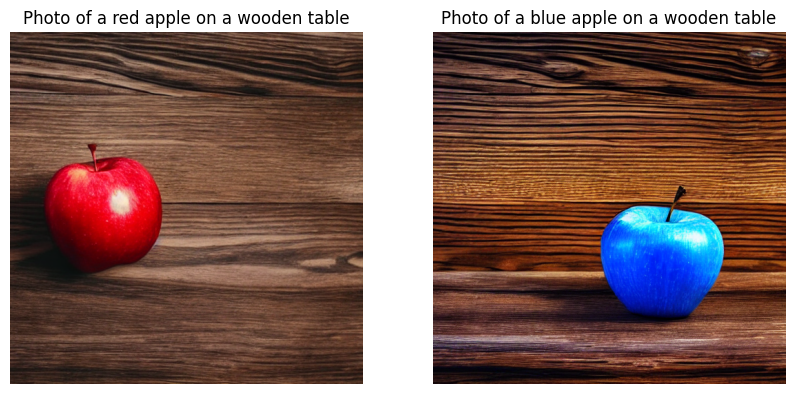

In [8]:
# =========================================================
# TEST: Prompt-to-Prompt (horse → dragon)
# =========================================================
# original_prompt = "a cat riding on a motorcycle"
# output_prompt   = "a cat riding on a motorcycle"

# original_prompt = "a photo of Cristiano Ronaldo eating spaghetti"
# output_prompt   = "a photo of Cristiano Ronaldo eating pizza"

# original_prompt = "Photo of a red apple on a wooden table"
# output_prompt   = "Photo of a green apple on a wooden table"


# original_prompt = "a castle next to a river"
# output_prompt   = "children drawing of a castle next to a river"

# original_prompt = "lake on a mountain"
# output_prompt   = "lake on a mountain with snow"

# original_prompt = "A squirrel eating a burger"
# output_prompt   = "A lion eating a burger"
# equalizer = {"eating a burger": 1.2}

# original_prompt = "A girl riding a horse"
# output_prompt   = "A girl riding a zebra"
# equalizer = {"A girl riding a": 1.1}

# original_prompt = "a photo of Cristiano Ronaldo eating spaghetti"
# output_prompt   = "a photo of Cristiano Ronaldo eating pizza"
# equalizer = {"a photo of Cristiano Ronaldo eating ": 1.5, "pizza":1.0}


# original_prompt = "a lake on a mountain"
# output_prompt   = "a lake on a mountain with fireworks"
# equalizer = {"a lake on a mountain ": 1.2}

# original_prompt = "a lake on a mountain"
# output_prompt   = "a lake on a mountain with fireworks"
# equalizer = {"a lake on a mountain ": 1.1}

# original_prompt = "a cat sitting on a car"
# output_prompt   = "a dog sitting on a car"
# equalizer = {"sitting on a car": 1.2}

# original_prompt = "A girl riding a horse"
# output_prompt   = "A girl riding a dragon"
# equalizer = {"A girl riding a": 1.2}

# original_prompt = "a lake in a mountain at midday"
# output_prompt   = "a lake in a mountain at sunset"
# equalizer = {"a lake in a mountain at": 1.2}

original_prompt = "Photo of a red apple on a wooden table"
output_prompt   = "Photo of a blue apple on a wooden table"
equalizer = {"Photo of a ": 1.2, "blue": 1, "apple on a wooden table":1.2}

SEED = 1000 #20230330
edit_type = "edit"

before, after = p2p_edit(
    sd_t2i,
    src_prompt=original_prompt,
    tgt_prompt=output_prompt,
    seed=SEED,
    steps=50,
    guidance_scale=7.5,
    width=512, height=512,
    negative_prompt="", # "blurry, low quality, distorted"
    replace_ratio = 0.9,
    equalizer = equalizer,
    alpha=0.9
)

show_pair(before, after, (original_prompt, output_prompt))


In [9]:
# === Calcolo metriche CLIP ===
dir_sim = clip_directional_similarity(before, after, original_prompt, output_prompt)
img_sim = clip_image_similarity(before, after)
img_caption_sim_before = clip_image_caption_similarity(before, original_prompt)
img_caption_sim_after  = clip_image_caption_similarity(after, output_prompt)


# === Stampa risultati ===
print(f"[CLIP] Directional similarity:         {dir_sim:.4f}")
print(f"[CLIP] Image similarity:               {img_sim:.4f}")
print(f"[CLIP] Image-caption similarity (before): {img_caption_sim_before:.4f}")
print(f"[CLIP] Image-caption similarity (after):  {img_caption_sim_after:.4f}")

# === Verifica criteri ===
passed = True
if img_sim < 0.75:
    print("❌ Image-image similarity troppo bassa (< 0.75)")
    passed = False
if dir_sim < 0.20:
    print("❌ Directional similarity troppo bassa (< 0.20)")
    passed = False
if img_caption_sim_before < 0.20:
    print("❌ Image-caption similarity (before) troppo bassa (< 0.20)")
    passed = False
if img_caption_sim_after < 0.20:
    print("❌ Image-caption similarity (after) troppo bassa (< 0.20)")
    passed = False

if passed:
    print("✅ Tutti i criteri CLIP rispettati!")

[CLIP] Directional similarity:         0.2789
[CLIP] Image similarity:               0.9066
[CLIP] Image-caption similarity (before): 0.3266
[CLIP] Image-caption similarity (after):  0.3712
✅ Tutti i criteri CLIP rispettati!


In [10]:
import random

@torch.no_grad()
def p2p_edit_best(pipe,
                 src_prompt,
                 tgt_prompt,
                 seed=None,
                 steps=50,
                 guidance_scale=7.5,
                 width=512, height=512,
                 negative_prompt="",
                 num_images=5,
                 equalizer=None):

    
    g = torch.Generator(DEVICE).manual_seed(seed)
    
    controller = P2PControllerEdit(
        tokenizer=pipe.tokenizer,
        src_prompt=src_prompt,
        tgt_prompt=tgt_prompt,
        replace_ratio=1.0,
        equalizer=equalizer,
        alpha=1.0
    )
        
    old_processors = pipe.unet.attn_processors
    proc_dict = _build_attn_processor_dict(pipe.unet, controller)
    pipe.unet.set_attn_processor(proc_dict)

    cb = _make_callback(controller, steps)
    
    controller.mode = "store"
    images_src = pipe(
        prompt=src_prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=steps,
        guidance_scale=guidance_scale,
        width=width, height=height,
        generator=g,
        callback=cb,
        callback_steps=1,
    ).images
    img_src = images_src[0]

    # Ora generiamo num_images immagini con valori casuali di replace_ratio e alpha
    controller.mode = "edit"
    best_img = None
    best_score = -float('inf')

    for i in range(num_images):
        # Genera valori casuali
        replace_ratio = random.uniform(0.1, 0.9)
        alpha = random.uniform(0.0, 1.0)

        # Aggiorna controller con i nuovi parametri
        if edit_type == "swap":
            controller.replace_ratio = replace_ratio
            # swap potrebbe non usare alpha
        elif edit_type == 'add_phrase':
            controller.replace_ratio = replace_ratio
            controller.alpha = alpha
        else:
            controller.replace_ratio = replace_ratio
            controller.alpha = alpha

        
        g2 = torch.Generator(DEVICE).manual_seed(seed)

        images_tgt = pipe(
            prompt=tgt_prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=steps,
            guidance_scale=guidance_scale,
            width=width, height=height,
            generator=g2,
            callback=cb,
            callback_steps=1,
        ).images

        img_tgt = images_tgt[0]

        # Calcola la metrica che vuoi usare, ad esempio similarità caption-immagine
        score1 = clip_directional_similarity(img_src, img_tgt, src_prompt, tgt_prompt)
        score2 = clip_image_similarity(img_src, img_tgt)
        score3 = clip_image_caption_similarity(img_tgt, tgt_prompt)

        score = (score1 + score2 + score3) / 3 
        
        print(f"Immagine {i}: replace_ratio={replace_ratio:.2f}, alpha={alpha:.2f}, score={score:.4f}")

        if score > best_score:
            best_score = score
            best_img = img_tgt

    pipe.unet.set_attn_processor(old_processors)
    return img_src, best_img


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 0: replace_ratio=0.47, alpha=0.89, score=0.5847


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 1: replace_ratio=0.29, alpha=0.29, score=0.5718


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 2: replace_ratio=0.85, alpha=0.10, score=0.5717


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 3: replace_ratio=0.75, alpha=0.84, score=0.5777


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 4: replace_ratio=0.41, alpha=0.09, score=0.5688


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 5: replace_ratio=0.29, alpha=0.28, score=0.5694


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 6: replace_ratio=0.27, alpha=0.84, score=0.5879


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 7: replace_ratio=0.60, alpha=0.00, score=0.5681


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 8: replace_ratio=0.86, alpha=0.89, score=0.5760


  0%|          | 0/40 [00:00<?, ?it/s]

Immagine 9: replace_ratio=0.60, alpha=0.70, score=0.5818


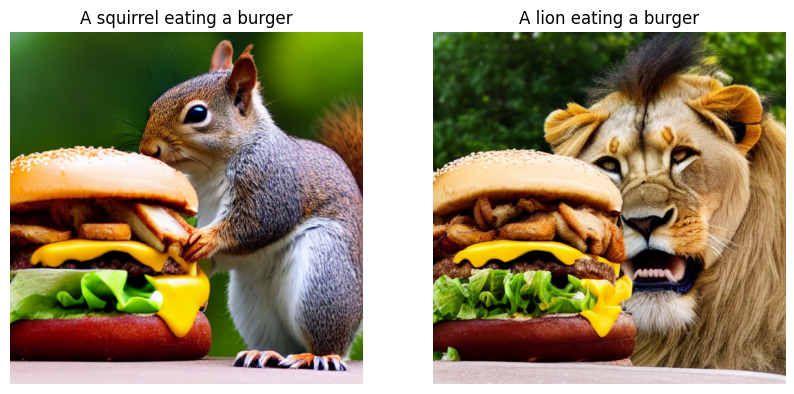

[CLIP] Directional similarity:         0.5138
[CLIP] Image similarity:               0.8756
[CLIP] Image-caption similarity (before): 0.3459
[CLIP] Image-caption similarity (after):  0.3744
✅ Tutti i criteri CLIP rispettati!


In [13]:
original_prompt = "A squirrel eating a burger"
output_prompt   = "A lion eating a burger"
equalizer = {"eating a burger": 1.2}


SEED=20230330

before, after = p2p_edit_best(
    sd_t2i,
    src_prompt=original_prompt,
    tgt_prompt=output_prompt,
    steps=40,
    seed=SEED,
    guidance_scale=7.5,
    width=512, height=512,
    negative_prompt="",
    num_images=10,
    equalizer=equalizer
)


show_pair(before, after, (original_prompt, output_prompt))

# === Calcolo metriche CLIP ===
dir_sim = clip_directional_similarity(before, after, original_prompt, output_prompt)
img_sim = clip_image_similarity(before, after)
img_caption_sim_before = clip_image_caption_similarity(before, original_prompt)
img_caption_sim_after  = clip_image_caption_similarity(after, output_prompt)

# === Stampa risultati ===
print(f"[CLIP] Directional similarity:         {dir_sim:.4f}")
print(f"[CLIP] Image similarity:               {img_sim:.4f}")
print(f"[CLIP] Image-caption similarity (before): {img_caption_sim_before:.4f}")
print(f"[CLIP] Image-caption similarity (after):  {img_caption_sim_after:.4f}")
# === Verifica criteri ===

passed = True
if img_sim < 0.75:
    print("❌ Image-image similarity troppo bassa (< 0.75)")
    passed = False
if dir_sim < 0.20:
    print("❌ Directional similarity troppo bassa (< 0.20)")
    passed = False
if img_caption_sim_before < 0.20:
    print("❌ Image-caption similarity (before) troppo bassa (< 0.20)")
    passed = False
if img_caption_sim_after < 0.20:
    print("❌ Image-caption similarity (after) troppo bassa (< 0.20)")
    passed = False

if passed:
    print("✅ Tutti i criteri CLIP rispettati!")
